In [1]:
import torch
import torchvision
from torch.utils.data import Dataset
import torchvision.transforms.functional as fn
import torchvision.transforms as T
import matplotlib.pyplot as plt
from utilities import createAnnotation
import pandas as pd
from IPython.display import display
from PIL import Image 

In [2]:
IMAGESROOTDIR = 'NINCO_OOD_classes'

In [3]:
class ImageDataset(Dataset):
    def __init__(self, rootDir):
        self.rootDir = rootDir
        createAnnotation(self.rootDir)
        self.annotation =  pd.read_csv('output.csv')


    def __getitem__(self, index):
        data_path = self.annotation.iloc[index,0]
        image = Image.open(data_path)
        label = self.annotation.iloc[index,1]
        return image, label

    def __len__(self):
        return len(self.annotation)

In [4]:
# instance of class ImageDataset
# contains all 765 images with their respective labels
imageDataset = ImageDataset(rootDir=IMAGESROOTDIR)

In [5]:
# Class which is used to rescale the image to a given size
# input: outputSize: int
# return: tuple(PIL Image, label)
class Rescale:
    def __init__(self, outputSize):
        self.outputSize = outputSize   
        
        
    def __calculateNewSize(self, size):
        initialWidth, initialHeight = size
        
        
        RATIO = initialWidth/self.outputSize
        newWidth = self.outputSize
        newHeight = initialHeight/RATIO
        
        return (round(newWidth), round(newHeight))  
        
    #sample data is a tuple(image, label)
    def __call__(self, sampleData):
        image, label = sampleData
        
        size = image.size
        
        newWidth, newHeight = self.__calculateNewSize(size)
        
        transformedImage = fn.resize(image, [newHeight, newWidth])
        
        return transformedImage,label

In [22]:
# Class which is used to center crop non quadratic images
# input: outputSize: int
# return: tuple(PIL Image, label)
class CenterCrop:
    def __init__(self, outputSize):
        self.outputSize = outputSize
        
    # creates a quadratic image
    def __call__(self, sampleData):
        image, label = sampleData
        
        width, height = image.size
        
        if (width != height):
            centerCrop = torchvision.transforms.CenterCrop(self.outputSize)

            return centerCrop(image), label
        return image,label

In [23]:
rescale = Rescale(244)
crop = CenterCrop(244)
composed = T.Compose([rescale, crop])

# given an Index returns the transformed Immage
# input: Index: int
# return: tuple(PIL Image, label)
def transform(index):
    tmp = composed(imageDataset[index])
    return tmp

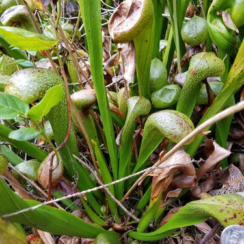

darlingtonia_californica
